# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [4]:
config = mlm_config();

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'multi_data_idxenc.pkl'

## MSKLM

In [6]:
data = load_data(numpy_path, data_save_name, bs=1)
vocab = data.vocab
learn = multitask_model_learner(data, config.copy())

## Load existing

In [7]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [8]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [9]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [10]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [14]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

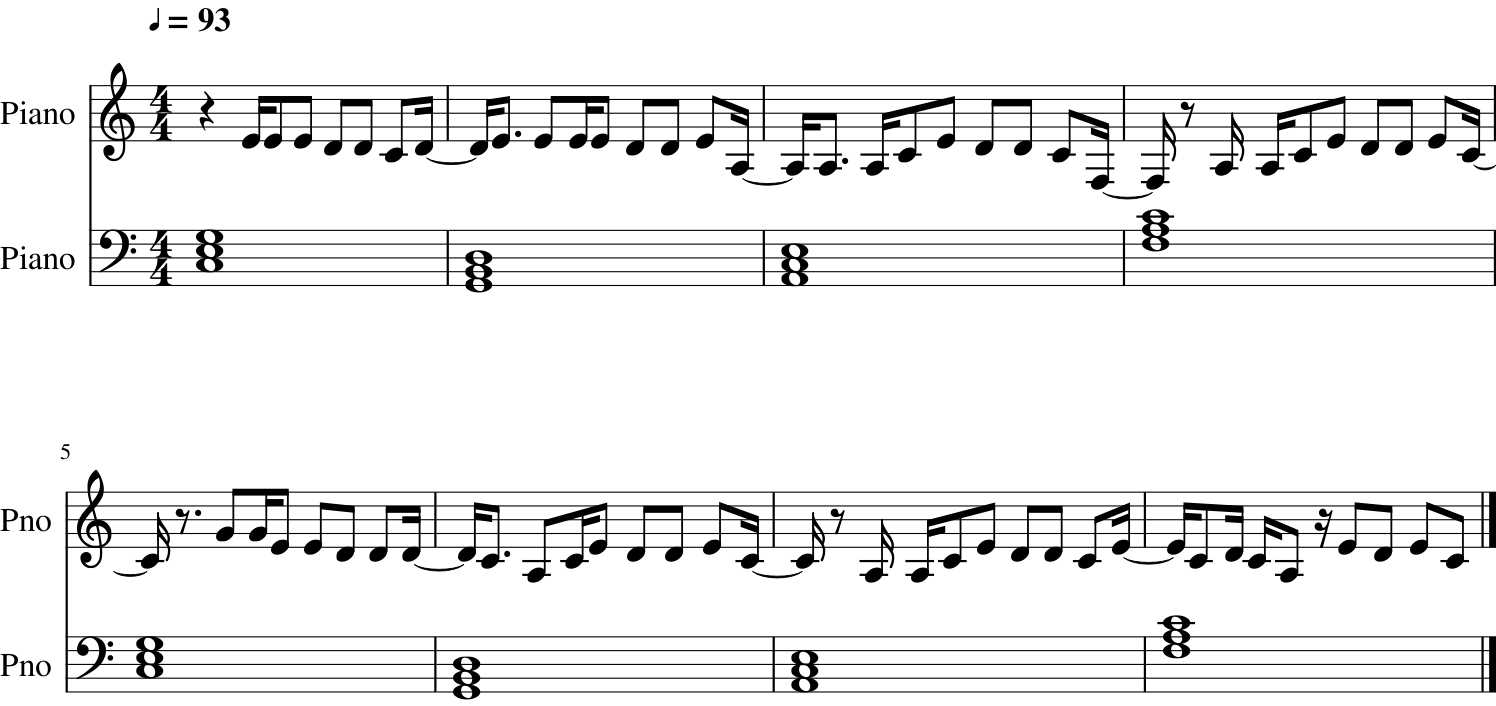

In [16]:
item.show()

In [17]:
item.show_midi()

## Predict Mask

#### Regenerate durations

In [18]:
# duration mask
x_dur = mask_input(x, mask_range=vocab.dur_range, replacement_idx=vocab.mask_idx)
pred = learn.predict_mask(x_dur, x_pos, 
                          temperatures=(0.8,0.8), top_k=40, top_p=0.6)

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 7 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


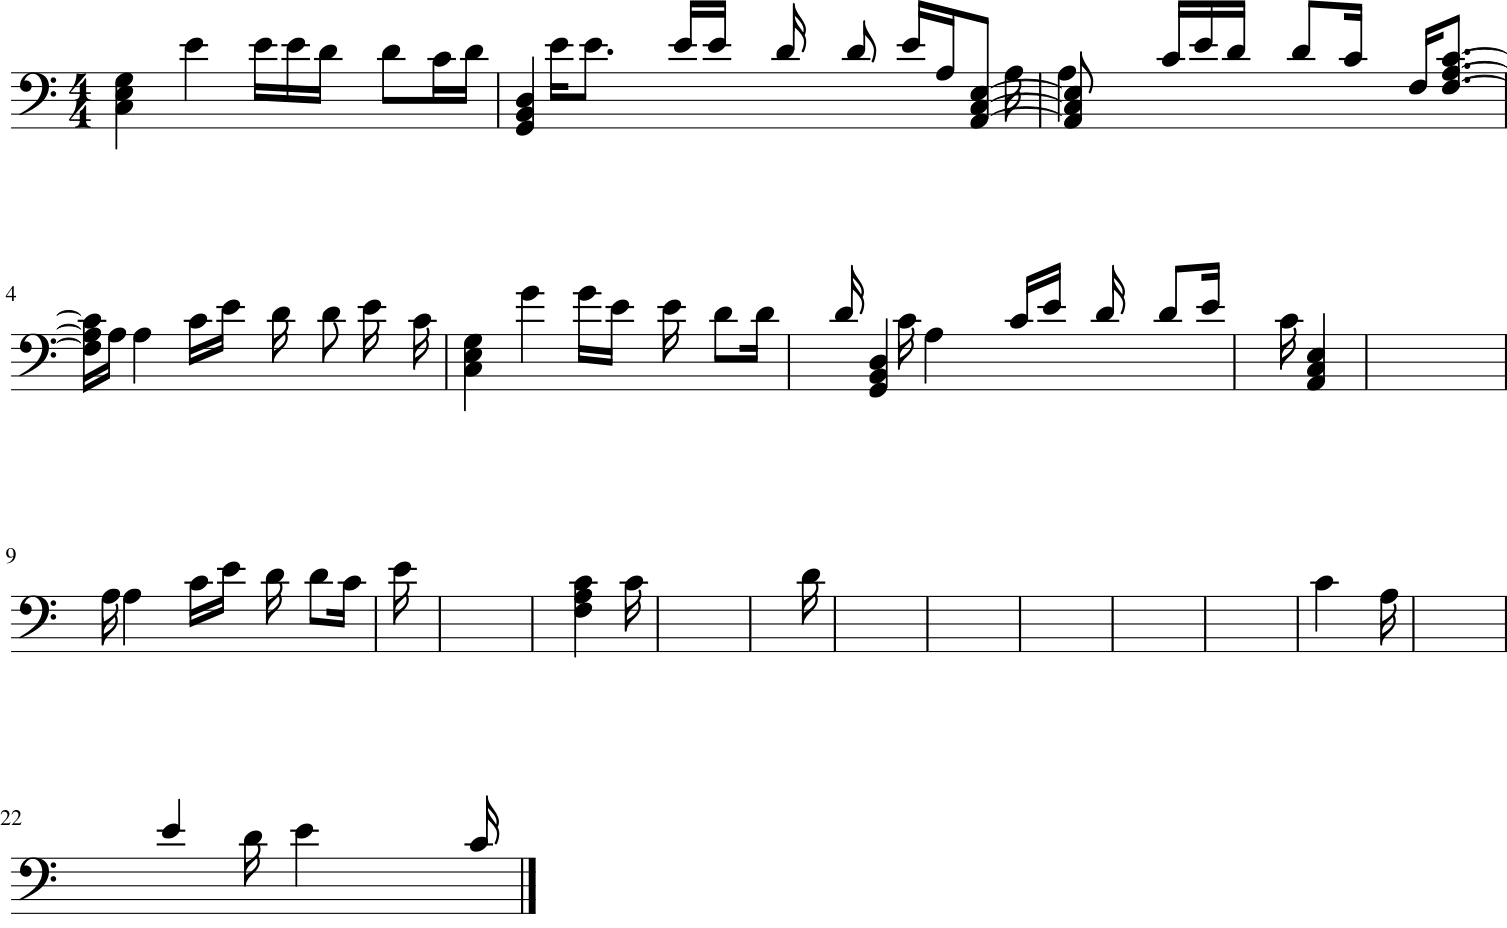

In [19]:
dur_item = vocab.musicify(pred)
dur_item.show()

In [20]:
dur_item.show_midi()

#### Regenerate Notes

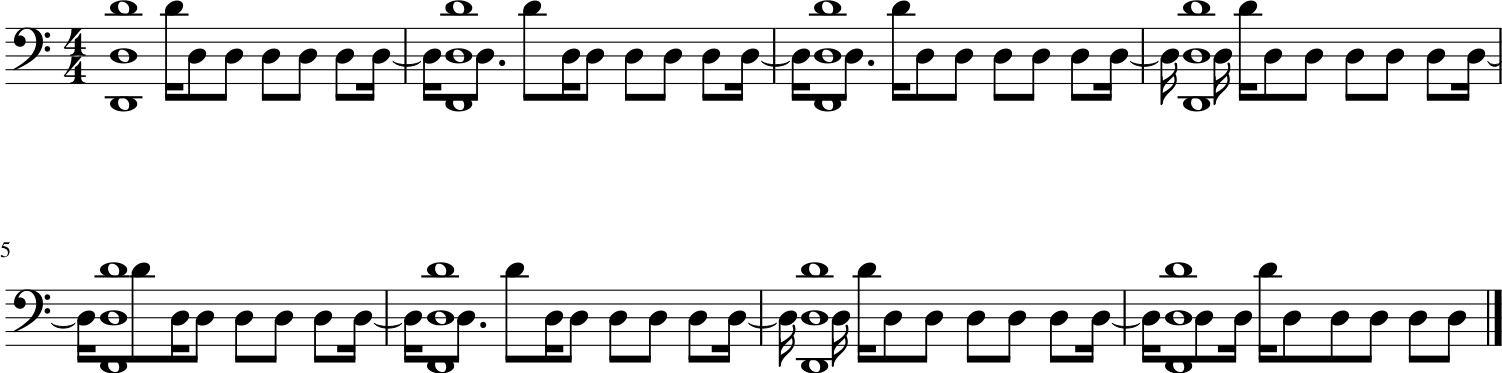

In [21]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
x_note = mask_input(x, mask_range=vocab.note_range, replacement_idx=vocab.mask_idx)
pred_note = learn.predict_mask(x_note)

note_item = vocab.musicify(pred_note)
note_item.show()

In [22]:
# vocab.textify(pred_note)

In [23]:
note_item.show_midi()

In [24]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

In [25]:
vocab.musicify(out).show_midi()

## Prediction next word

In [26]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

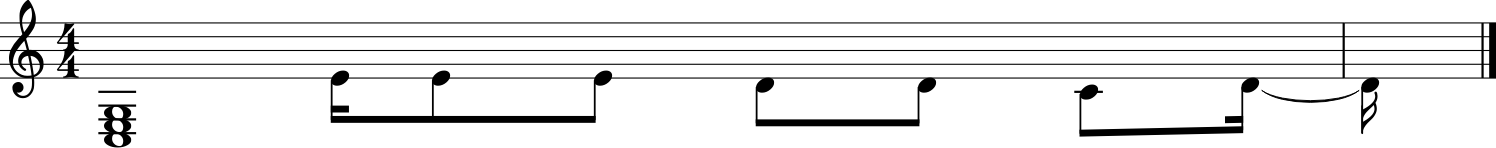

In [27]:
seed.show()

In [28]:
out = learn.predict_nw(seed.to_tensor(), n_words=200)

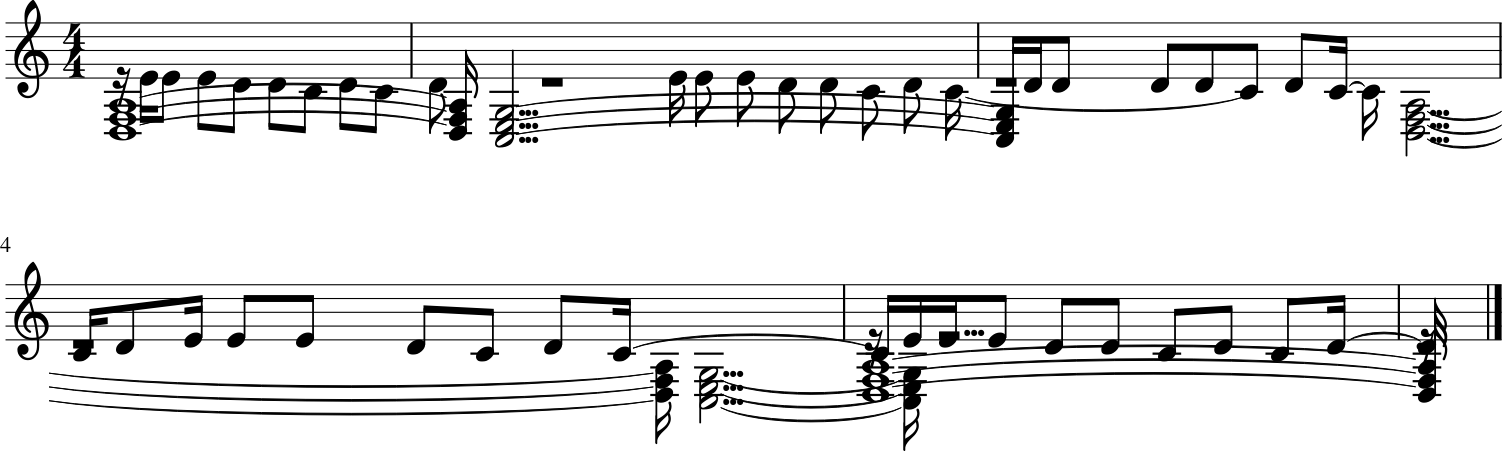

In [29]:
stream = vocab.musicify(out)
stream.show()

In [30]:
stream.show_midi()

## Prediction next word

In [31]:
seed_len = 4 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

In [51]:
t = torch.tensor([[]]).cuda().long()

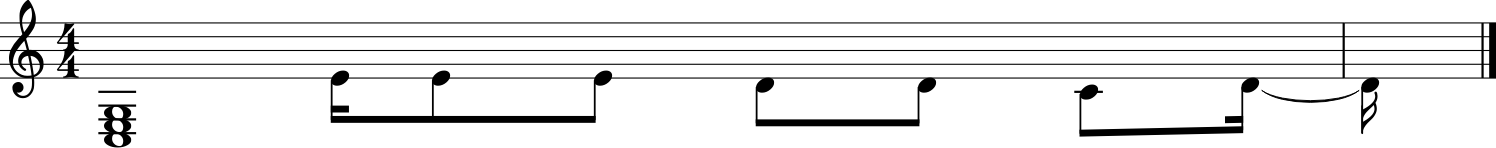

In [52]:
seed.show()

In [53]:
t[-1]

tensor([], device='cuda:0', dtype=torch.int64)

In [54]:
def predict_nw(self, xb:Tensor, n_words:int=128,
                 temperatures:float=(1.0,1.0), min_bars=4,
                 top_k=30, top_p=0.6):
    "Return the `n_words` that come after `text`."
    self.model.reset()
    new_idx = []
    vocab = self.data.vocab
    xb = xb.squeeze()
    pos = torch.tensor(neg_position_enc(xb.cpu().numpy(), vocab), device=xb.device)
    last_pos = pos[-1] if pos.shape[0] > 0 else 0
    yb = torch.tensor([0])

    sep_count = 0
    bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
    vocab = self.data.vocab

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):
            batch = { 'lm': { 'x': xb[None], 'pos': pos[None] } }, yb
            res = self.pred_batch(batch=batch)['lm'][-1][-1]
            res = F.softmax(res, dim=-1)

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[vocab.bos_idx] = 0.

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(new_idx)==0 or vocab.is_duration(new_idx[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()

            if new_idx and new_idx[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                sep_count += duration
                last_pos = last_pos - duration # position is negative

            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break

            new_idx.append(idx)
            xb = xb.new_tensor([idx])
            pos = pos.new_tensor([last_pos])
    return np.array(new_idx)


In [62]:
from src.utils.midifile import is_empty_midi

In [64]:
is_empty_midi(file)

False

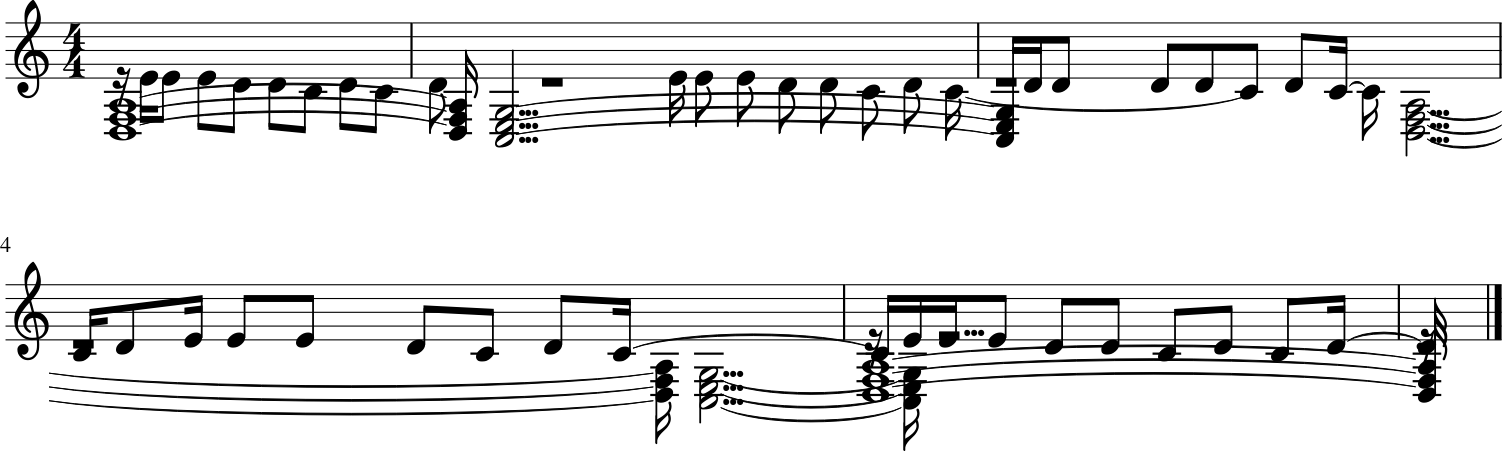

In [29]:
stream = vocab.musicify(out)
stream.show()

In [30]:
stream.show_midi()

Convenience function

In [ ]:

def nw_predict_from_midi(learn, midi=None, n_words=600, 
                      temperatures=(1.0,1.0), top_k=30, top_p=0.6, seed_len=None, **kwargs):
    vocab = learn.data.vocab
    
    item = MusicItem.from_file(midi, learn.data.vocab) if not is_empty_file(midi) else MusicItem.empty(vocab)
    
    try:
        seed_np = midi2idxenc(midi, vocab=vocab) # music21 can handle bytes directly
        if seed_len is not None:
            seed_np = trim_tfm(seed_np, vocab=vocab, to_beat=seed_len)
    except IndexError:
        # midi file has empty notes/tracks. Create empty stream
        seed_np = npenc2idxenc(np.zeros((0, 2), dtype=int))
    x = torch.tensor(seed_np)
    if torch.cuda.is_available(): x = x.cuda()
    pred = learn.predict_nw(x, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p)
    return np.concatenate((seed_np,pred), axis=0)


In [29]:
out = nw_predict_from_midi(learn, file, seed_len=4, top_k=30, top_p=0.5)

In [30]:
# stream = idxenc2stream(out)
# stream.show()

# stream.show('midi')

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

## Predict Seq2Seq

In [ ]:

def pad_seq(seq, bptt, value):
    pad_len = max(bptt-seq.shape[0], 0)
    return np.pad(seq, [(0, pad_len),(0,0)], 'constant', constant_values=value)[:bptt]
    
def partenc2seq2seq(part_np, part_type, vocab, add_eos=True):
    part_meta = np.array([vocab.stoi[part_type], vocab.pad_idx])
    s2s_out = npenc2idxenc(part_np, vocab=vocab, start_seq=part_meta)
    if add_eos: s2s_out = np.pad(s2s_out, (0,1), 'constant', constant_values=vocab.stoi[EOS])
    return s2s_out

def s2s_combine2chordarr(np1, np2, vocab):
    if len(np1.shape) == 1: np1 = idxenc2npenc(np1, vocab)
    if len(np2.shape) == 1: np2 = idxenc2npenc(np2, vocab)
    p1 = npenc2chordarr(np1)
    p2 = npenc2chordarr(np2)
    return chordarr_combine_parts(p1, p2)

def midi_extract_melody_chords(midi, vocab):
    stream = file2stream(midi) # 1.
    chordarr = stream2chordarr(stream) # 2.
    _,num_parts,_ = chordarr.shape

    if num_parts == 1:
        # if predicting melody, assume only track is chord track
        p1, p2 = part_enc(chordarr, 0), np.zeros((0,2), dtype=int)
        p1, p2 = (p2, p1) if pred_melody else (p1, p2)
    elif num_parts == 2:
        p1, p2 = [part_enc(chordarr, i) for i in range(num_parts)]
        p1, p2 = (p1, p2) if avg_pitch(p1) > avg_pitch(p2) else (p2, p1)
    else:
        raise ValueError('Could not extract melody and chords from midi file. Please make sure file contains exactly 2 tracks')
        
    mpart = partenc2seq2seq(p1, part_type=MSEQ, vocab=vocab)
    cpart = partenc2seq2seq(p2, part_type=CSEQ, vocab=vocab)
    return mpart, cpart

In [35]:
melody, chords = midi_extract_melody_chords(file, vocab)

## Predict melody

In [40]:
partial_melody = trim_tfm(melody, vocab, to_beat=3)

In [41]:
idxenc2stream(melody_cut).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

In [ ]:
xb_msk = torch.tensor(chords).cuda()
xb_lm = torch.tensor(melody_cut).cuda()

In [ ]:
xb_msk.shape, xb_lm.shape

In [ ]:
out = learn.predict_s2s(xb_msk, xb_lm)

In [ ]:
idxenc2stream(out).show()

In [ ]:
chordarr_comb = s2s_combine2chordarr(out, chords)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [ ]:
comb_stream.show('midi')

## Predict chords

In [ ]:
chord_cut = seed_tfm(chords, seed_len=3)

In [ ]:
idxenc2stream(chord_cut).show()

In [31]:
xb_msk = torch.tensor(melody).cuda()
xb_lm = torch.tensor(chord_cut).cuda()

NameError: name 'melody' is not defined

In [32]:
xb_msk.shape, xb_lm.shape

NameError: name 'xb_msk' is not defined

In [33]:
out = learn.predict_s2s(xb_msk, xb_lm)

NameError: name 'xb_msk' is not defined

In [34]:
idxenc2stream(out).show()

TypeError: idxenc2stream() missing 1 required positional argument: 'vocab'

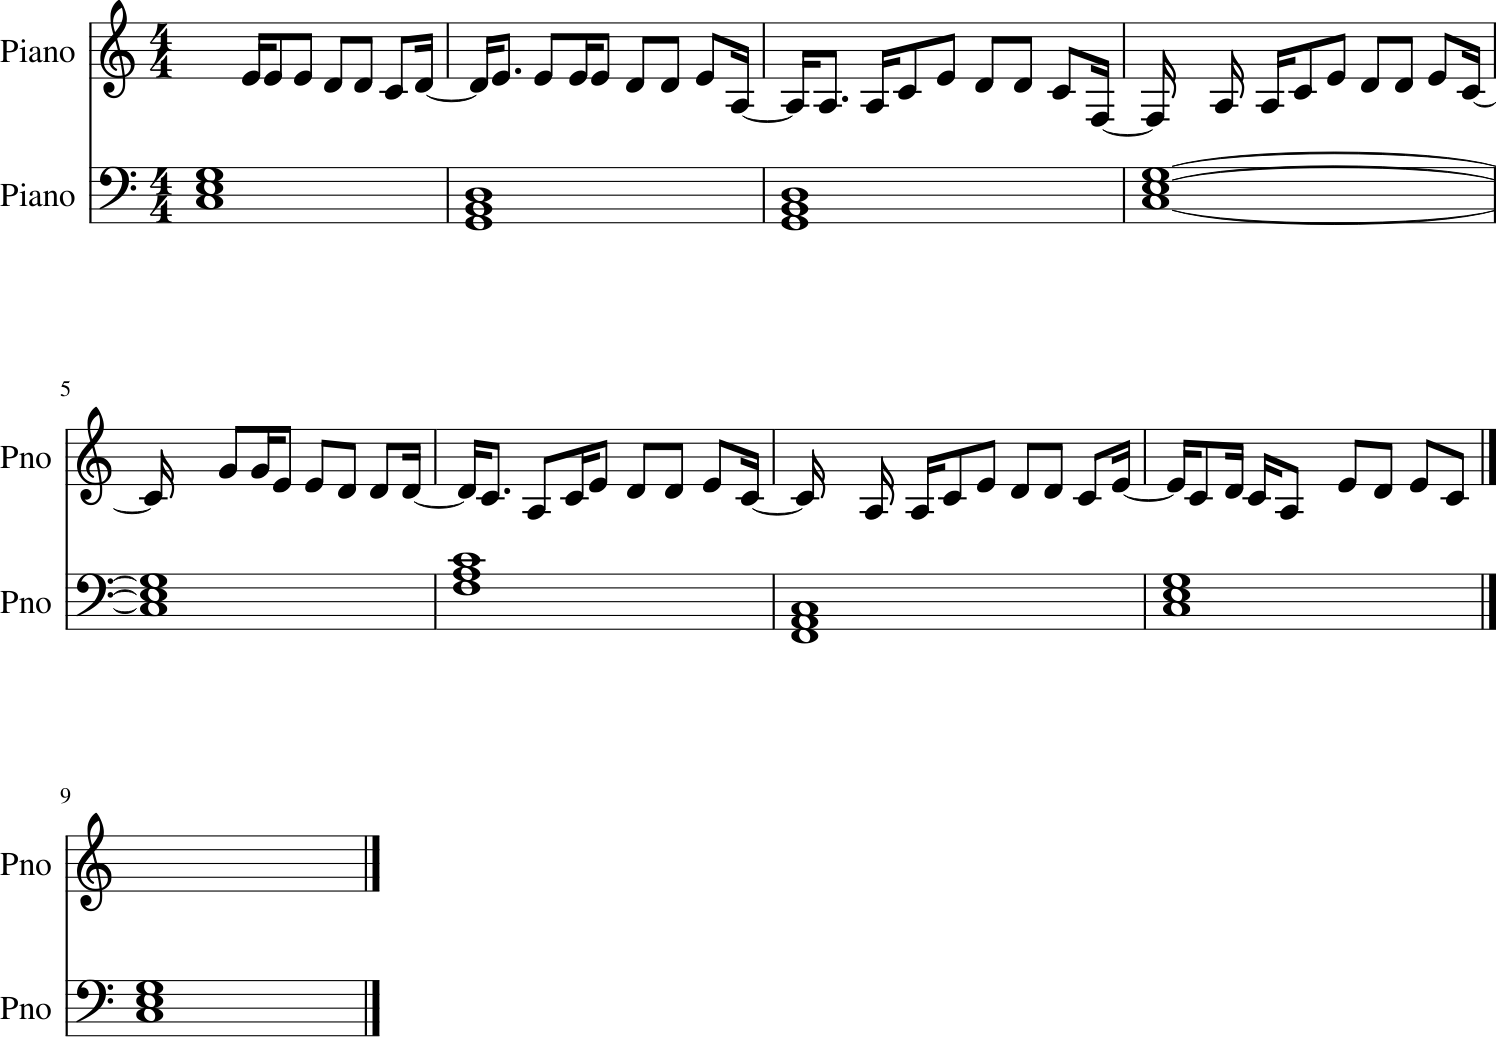

In [54]:
chordarr_comb = s2s_combine2chordarr(melody, out)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [55]:
comb_stream.show('midi')

Convenience Function

In [56]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


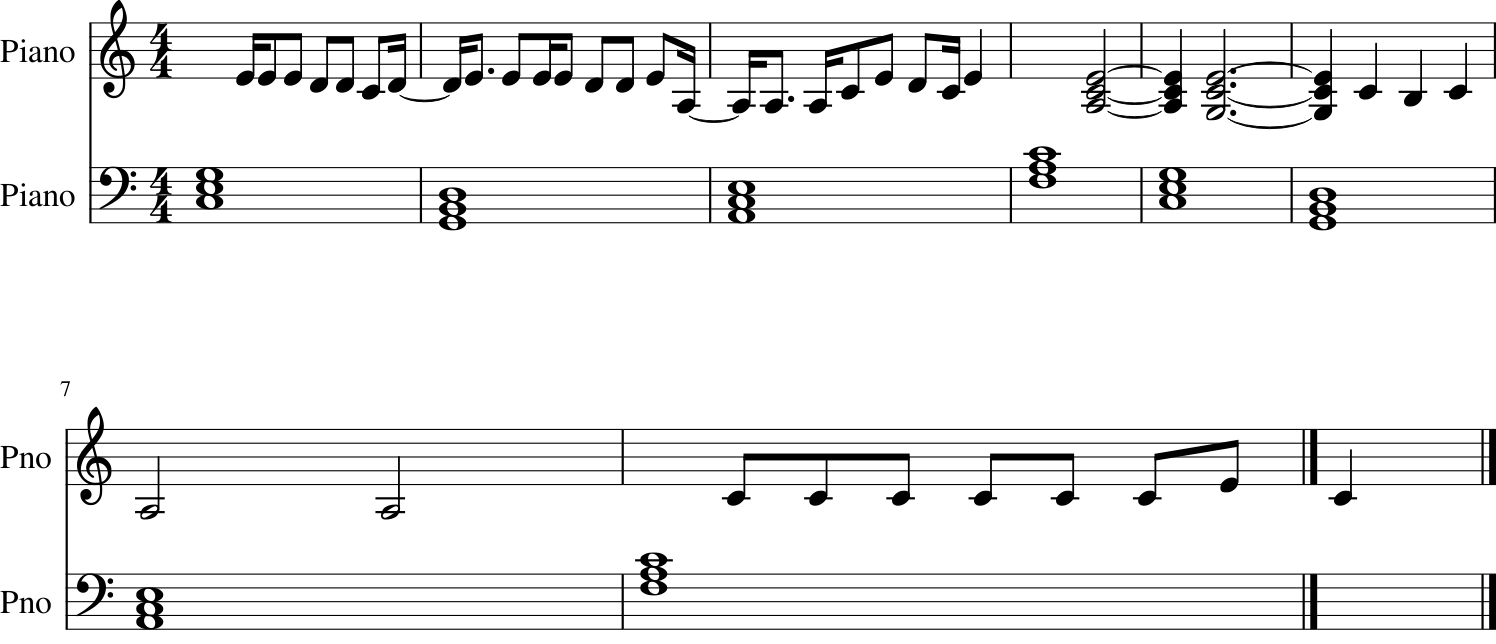

In [57]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()